<a href="https://colab.research.google.com/github/ED1-WELL/wheeled_pupper_collab/blob/main/Driving_Collab_Ethan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authors
Google (thanks Baruch!) + Nathan + Gabrael, minor modifications from Ankush and JC for CS 123 purposes

# GPU
Please connect to an **A100** GPU to run the following notebook.

In [1]:
# Prompt user for run name
print("Please enter a name for this run in the box below.")
run_name = input("Run Name (press Enter for auto-generated): ").strip()
if not run_name:
    run_name = None

Please enter a name for this run in the box below.
Run Name (press Enter for auto-generated): harsher2


# Log in to Weights and Biases

Paste your wandb key in the section below to log all your training processes

In [2]:
from google.colab import userdata
try:
  wandb_key = userdata.get('wandb_key')
except userdata.SecretNotFoundError:
  # Paste your wandb key here
  wandb_key = 'fe8596894517233dd099cb1bd8dfe76f9528b126'

In [3]:
!pip install -q wandb
import wandb
wandb.login(key=wandb_key if wandb_key else None)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: edretzka (edretzka-university-of-wisconsin-madison) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Install dependencies (no need to open this)

In [4]:
!pip install -q mujoco==3.2.7 mujoco-mjx==3.2.7 brax==0.10.5 flax==0.10.2 orbax==0.1.9
!pip install black[jupyter] --quiet
import os
# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
# Clean up incompatible jax versions
!pip uninstall -y jax jaxlib optax orbax-checkpoint

# Install specific compatible jax versions
!pip install optax==0.2.2 orbax-checkpoint==0.11.10
!pip install "jax[cuda12]==0.5.0" "jax-cuda12-plugin==0.5.0" "jax-triton==0.2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.9/998.9 kB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.2/424.2 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.4/740.4 kB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
#@title Check if MuJoCo installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [6]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [7]:
#@title Import MuJoCo, MJX, and Brax


from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Config

## pupperv3-mjx repo config (no need to open this)

In [8]:
pupperv3_mjx_config = config_dict.ConfigDict()
pupperv3_mjx_config.branch = "Ethan_test"

In [9]:
!rm -rf pupperv3_mjx
# Using JC's version in case there's an update in the future
!git clone https://github.com/ED1-WELL/mjx_Wheels_pupperv3.git -b {pupperv3_mjx_config.branch}
!mv mjx_Wheels_pupperv3 pupperv3_mjx
!cd pupperv3_mjx && git pull && pip install -q .

Cloning into 'mjx_Wheels_pupperv3'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 87 (delta 38), reused 73 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 994.25 KiB | 1.44 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Already up to date.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 139.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 28.0 MB/s eta 0:00:00


## Simulation Config (no need to open this)

In [10]:
# Pupper model configuration
simulation_config = config_dict.ConfigDict()
simulation_config.model_repo = 'https://github.com/ED1-WELL/description_Wheels_pupperv3.git'
simulation_config.model_branch = 'Ethan_test'

!rm -rf pupper_v3_description
!git clone {simulation_config.model_repo} -b {simulation_config.model_branch}
!cd pupper_v3_description && git pull

Cloning into 'description_Wheels_pupperv3'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 199 (delta 124), reused 155 (delta 81), pack-reused 0 (from 0)
Receiving objects: 100% (199/199), 11.70 MiB | 6.62 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/bin/bash: line 1: cd: pupper_v3_description: No such file or directory


In [11]:
# Select model
# simulation_config.original_model_path = 'pupper_v3_description/description/mujoco_xml/pupper_v3_complete.mjx.position.no_body.self_collision.stable.xml'
# simulation_config.original_model_path = 'pupper_v3_description/description/mujoco_xml/pupper_v3_complete.mjx.position.no_body.self_collision.less_stable.xml'

# simulation_config.original_model_path = 'pupper_v3_description/description/mujoco_xml/pupper_v3_complete.mjx.position.no_body.self_collision.weak.xml' # 2Nm max
#simulation_config.original_model_path = 'pupper_v3_description/description/mujoco_xml/pupper_v3_complete.mjx.position.no_body.self_collision.two_iterations.xml' # 3Nm max
simulation_config.original_model_path = 'description_Wheels_pupperv3/description/mujoco_xml/Wheel_pupper.xml' # 3Nm max
# simulation_config.original_model_path = 'pupper_v3_description/description/mujoco_xml/pupper_v3_complete.mjx.position.no_body.self_collision.xml' # 3Nm max

# simulation_config.original_model_path = 'pupper_v3_description/description/mujoco_xml/pupper_v3_complete.mjx.position.no_body.xml'
# simulation_config.original_model_path = 'pupper_v3_description/description/mujoco_xml/pupper_v3_complete.mjx.position.xml'
simulation_config.model_xml = epath.Path(simulation_config.original_model_path).read_text()
simulation_config.model_path = "description_Wheels_pupperv3/description/mujoco_xml/model_with_obstacles.xml"

# Model body names
simulation_config.upper_leg_body_names = ["leg_front_r_2", "leg_front_l_2", "leg_back_r_2", "leg_back_l_2"]
#simulation_config.lower_leg_body_names = ["leg_front_r_3", "leg_front_l_3", "leg_back_r_3", "leg_back_l_3"]
simulation_config.lower_leg_body_names = ["Wheel_FR","Wheel_FL","Wheel_BR","Wheel_BL"]
simulation_config.foot_site_names = [
    "leg_front_r_3_foot_site",
    "leg_front_l_3_foot_site",
    "leg_back_r_3_foot_site",
    "leg_back_l_3_foot_site",
]
simulation_config.torso_name = "base_link"

# Foot radius
simulation_config.foot_radius = 0.02

# Collision detection
simulation_config.max_contact_points = 8 # Default: 5 # 8
simulation_config.max_geom_pairs = 8 # Default: 4 # 8

# TODO: This introduces a fundamental limit to the policy performance
# What happens here is we set the maximum angle that can be commanded to the
# joint equal to the actual joint limit. However, imagine if the joint is already
# near its limit. There's no way we can apply torque in the direction towards
# the limit because the max command is the joint limit. To allow torque even at
# the limit. We will need to increase the upper and lower limits and somehow
# penalize the robot for hitting the joint limits.

# Joint limits
sys_temp = mjcf.load(simulation_config.original_model_path)
joint_upper_limits = sys_temp.jnt_range[1:, 1]
joint_lower_limits = sys_temp.jnt_range[1:, 0]
simulation_config.joint_upper_limits = np.array(joint_upper_limits).tolist()
simulation_config.joint_lower_limits = np.array(joint_lower_limits).tolist()

# Physics timestep
simulation_config.physics_dt = 0.004 # Physics dt [s]

## Training Config

Training configs include:

*   configs controlling PPO (policy learning optimizer)
*   default joint angles
*   height fields
*   domain randomization parameters

**Modify with caution!**

In [12]:
from pupperv3_mjx import domain_randomization

import importlib

importlib.reload(domain_randomization)

training_config = config_dict.ConfigDict()
training_config.checkpoint_run_number = None

# Environment timestep
training_config.environment_dt = 0.02

# PPO params
training_config.ppo = config_dict.ConfigDict()
training_config.ppo.num_timesteps = 300_000_000   # Default: 300M
training_config.ppo.episode_length = 500         # Default: 1000
training_config.ppo.num_evals = 11                # Default: 10
training_config.ppo.reward_scaling = 1            # Default: 1
training_config.ppo.normalize_observations = True # Default: True
training_config.ppo.action_repeat = 1             # Default: 1
training_config.ppo.unroll_length = 20            # Default: 20
training_config.ppo.num_minibatches = 32          # Default: 32
training_config.ppo.num_updates_per_batch = 4     # Default: 4
training_config.ppo.discounting = 0.97            # Default: 0.97
training_config.ppo.learning_rate = 3.0e-5        # Default: 3.0e-4, 3.0e-5 was better than 3e-4
training_config.ppo.entropy_cost = 1e-2           # Default: 1e-2
training_config.ppo.num_envs = 8192               # Default: 8192
training_config.ppo.batch_size = 256              # Default: 256

# Command sampling
training_config.resample_velocity_step = training_config.ppo.episode_length // 2
training_config.lin_vel_x_range = [-0.75, 0.75]  # min max [m/s]. Default: [-0.75, 0.75]
training_config.lin_vel_y_range = [-0.5, 0.5]  # min max [m/s]. Default: [-0.5, 0.5]
training_config.ang_vel_yaw_range = [-2.0, 2.0]  # min max [rad/s]. Default: [-2.0, 2.0]
training_config.zero_command_probability = 0.02
training_config.stand_still_command_threshold = 0.05

# Orientation command sampling in degrees
training_config.maximum_pitch_command = 0.0
training_config.maximum_roll_command = 0.0

# Desired body orientation
training_config.desired_world_z_in_body_frame = (0.0, 0.0, 1.0) # Default: (0.0, 0.0, 1.0)

# Termination
# NOTE: without a body collision geometry, can't train recovery policy
training_config.terminal_body_z = 0.1  # Episode ends if body center goes below this height [m] Default: 0.10 m
training_config.terminal_body_angle = 0.52  # Episode ends if body angle relative to vertical is more than this. Default: 0.52 rad (30 deg)
training_config.early_termination_step_threshold = training_config.ppo.episode_length // 2 # Default: 500

# Joint PD overrides
training_config.dof_damping = 0.25  # Joint damping [Nm / (rad/s)] Default: 0.25
training_config.position_control_kp = 5.5  # Joint stiffness [Nm / rad] Default: 5.0

# Default joint angles
training_config.default_pose = jp.array(
    [0.26, 0.0, -0.52, -0.26, 0.0, 0.52, 0.26, 0.0, -0.52, -0.26, 0.0, 0.52]
)

# Desired abduction angles
training_config.desired_abduction_angles = jp.array(
    [0.0, 0.0, 0.0, 0.0]
)

# Height field
## Type of height field
training_config.height_field_random = False
training_config.height_field_steps = False
### Steps type params
training_config.height_field_step_size = 4
## General height field settings
training_config.height_field_grid_size = 256
training_config.height_field_group = "0"
training_config.height_field_radius_x = 10.0 # [m]
training_config.height_field_radius_y = 10.0 # [m]
training_config.height_field_elevation_z = 0.02 # [m]
training_config.height_field_base_z = 0.2 # [m]

# Domain randomization
## Perturbations
training_config.kick_probability = 0.0        # Kick the robot with this probability. ( ͡° ͜ʖ ͡°) Default: 0.04
training_config.kick_vel = 0.10               # Change the torso velocity by up to this much in x and y direction to simulate a kick [m/s] Default: 0.1
training_config.angular_velocity_noise = 0.1  # Default: 0.1 [rad/s]
training_config.gravity_noise = 0.05            # Default: 0.05 [u]
training_config.motor_angle_noise = 0.05        # Default: 0.05 [rad]
training_config.last_action_noise = 0.01       # Default: 0.01 [rad]

## Motors
training_config.position_control_kp_multiplier_range = (0.6, 1.1)
training_config.position_control_kd_multiplier_range = (0.8, 1.5)

## Starting position
training_config.start_position_config = domain_randomization.StartPositionRandomization(
    x_min=-2.0, x_max=2.0, y_min=-2.0, y_max=2.0, z_min=0.15, z_max=0.20
)

## Latency distribution
# Action latency
# 0 latency with 20% prob, 1 timestep latency with 80% prob
training_config.latency_distribution = jp.array([0.2, 0.8])

# IMU latency
# 0 latency with 50% prob, 1 timestep latency with 50% prob
training_config.imu_latency_distribution = jp.array([0.5, 0.5])

## Body CoM
training_config.body_com_x_shift_range = (-0.02, 0.02) # Default: -0.02, 0.02
training_config.body_com_y_shift_range = (-0.005, 0.005)
training_config.body_com_z_shift_range = (-0.005, 0.005)

## Mass and inertia randomization for all bodies
training_config.body_mass_scale_range = (0.9, 1.3)
training_config.body_inertia_scale_range = (0.9, 1.3)

## Friction
training_config.friction_range = (0.6, 1.4)

# Obstacles
training_config.n_obstacles = 0
training_config.obstacle_x_range = (-3.0, 3.0)  # [m]
training_config.obstacle_y_range = (-3.0, 3.0)  # [m]
training_config.obstacle_height = 0.04  # [m]
training_config.obstacle_length = 2.0  # [m]

## Policy config

These configs determine the policy architecure.

Don't change anything in this section unless you are absolutely sure what you are doing :-)

In [13]:
policy_config = config_dict.ConfigDict()

policy_config.use_imu = True # Whether to use IMU in policy. Default: True

policy_config.observation_history = 20  # number of stacked observations to give the policy

policy_config.action_scale = 0.75  # Default 0.75

policy_config.hidden_layer_sizes = (256, 128, 128, 128) # default (256, 128, 128, 128)

# RTNeural supports relu, tanh, sigmoid (not great), softmax, elu, prelu
# Swish was really good in terms of training but not supported in RTNeural rn
policy_config.activation = "elu"

##Reward Configuration
Below are the reward coefficients that you will adjust to guide the policy toward maximizing the desired behaviors.

Most of the work for this lab will focus on **tuning these coefficients**!

Be sure to carefully review the lab instructions to understand the exact implementation of each reward term — this is crucial for deciding whether each coefficient should be positive or negative.

In [14]:
reward_config = config_dict.ConfigDict()
reward_config.rewards = config_dict.ConfigDict()
reward_config.rewards.scales = config_dict.ConfigDict()

# Track linear velocity
reward_config.rewards.scales.tracking_lin_vel = 6

# Track the angular velocity along z-axis, i.e. yaw rate.
reward_config.rewards.scales.tracking_ang_vel = 5

# Track the given body orientation (desired world z axis in body frame)
# Not working right nowkick
reward_config.rewards.scales.tracking_orientation = 0.5

# Below are regularization terms, we roughly divide the
# terms to base state regularizations, joint
# regularizations, and other behavior regularizations.
# Penalize the base velocity in z direction, L2 penalty.
reward_config.rewards.scales.lin_vel_z = -0.5

# Penalize the base roll and pitch rate. L2 penalty.
reward_config.rewards.scales.ang_vel_xy = -0.05

# Penalize non-zero roll and pitch angles. L2 penalty.
reward_config.rewards.scales.orientation = -0.5

# L2 regularization of joint torques, sum(|tau|^2).
reward_config.rewards.scales.torques = -0.0001

# L2 regularization of joint accelerations sum(|qdd|^2)
reward_config.rewards.scales.joint_acceleration = -1e-7

# L1 regularization of mechanical work, |v * tau|.
reward_config.rewards.scales.mechanical_work = 0

# Penalize the change in the action and encourage smooth
# actions. L1 regularization |action - last_action|^2
reward_config.rewards.scales.action_rate = -0.01

# Encourage long swing steps. However, it does not
# encourage high clearances.
reward_config.rewards.scales.feet_air_time = 0

# Encourage joints at default position at zero command, L1 regularization
# |q - q_default|.
reward_config.rewards.scales.stand_still = 0

# Encourage zero joint velocity at zero command, L1 regularization
# |q_dot|.
# Activates when norm(command) < stand_still_command_threshold
# Commands below this threshold are sampled with probability zero_command_probability
reward_config.rewards.scales.stand_still_joint_velocity = 0

# Encourage zero abduction angle so legs don't spread so far out
# L2 loss on ||abduction_motors - desired||^2
reward_config.rewards.scales.abduction_angle = -4

# Early termination penalty.
reward_config.rewards.scales.termination = -100

# Penalizing foot slipping on the ground.
reward_config.rewards.scales.foot_slip = 0

# Penalize knees hitting the ground
reward_config.rewards.scales.knee_collision = -1.0

# Penalize body hitting ground
reward_config.rewards.scales.body_collision = -2.0

# Penalize wheels lifting up
reward_config.rewards.scales.wheels_on_ground = -150.0

# Tracking reward = exp(-error^2/sigma).
reward_config.rewards.tracking_sigma = 0.25

##Export config (no need to open this)

In [15]:
# Define the path to the subdirectory
export_config = config_dict.ConfigDict()
export_config.gdrive_save_dir = '/content/drive/MyDrive/pupper_policies'

## Github repo config (no need to open this)

In [16]:
import subprocess
def get_hash():
  return subprocess.check_output(['git', 'rev-parse', 'HEAD']).strip().decode('utf-8')

repo_config = config_dict.ConfigDict()
%cd /content/pupperv3_mjx
repo_config.pupperv3_mjx_hash = get_hash()
%cd /content/pupper_v3_description
repo_config.pupper_v3_description_hash = get_hash()
%cd /content

/content/pupperv3_mjx
[Errno 2] No such file or directory: '/content/pupper_v3_description'
/content/pupperv3_mjx
/content


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Create aggregated config (no need to open this)

In [17]:
temp_config = config_dict.ConfigDict()
temp_config.simulation = simulation_config
temp_config.training = training_config
temp_config.policy = policy_config
temp_config.reward = reward_config
temp_config.export = export_config
temp_config.repo = repo_config
temp_config.pupperv3_mjx = pupperv3_mjx_config

CONFIG = config_dict.FrozenConfigDict(temp_config)

# Prevent user from accidentally making changes to these configs which are not used
del temp_config, reward_config, policy_config, training_config, simulation_config, export_config

# Modify robot model

This section modifies the mjx environment. You won't need to know what's going on here for this lab :-)

##Set contact options

In [18]:
import xml.etree.ElementTree as ET
xml_str = epath.Path(CONFIG.simulation.original_model_path).read_text()
tree = ET.ElementTree(ET.fromstring(xml_str))

In [19]:
from pupperv3_mjx import utils
import importlib
importlib.reload(utils)

tree = utils.set_mjx_custom_options(tree,
                                    max_contact_points=CONFIG.simulation.max_contact_points,
                                    max_geom_pairs=CONFIG.simulation.max_geom_pairs)

##Add obstacles

In [20]:
from pupperv3_mjx import obstacles
import importlib
importlib.reload(obstacles)

tree = obstacles.add_boxes_to_model(
    tree,
    n_boxes=CONFIG.training.n_obstacles,
    x_range=CONFIG.training.obstacle_x_range,
    y_range=CONFIG.training.obstacle_y_range,
    height=CONFIG.training.obstacle_height,
    # depth=CONFIG.training.obstacle_depth,
    length=CONFIG.training.obstacle_length
)

## Add height field ground

In [21]:
if CONFIG.training.height_field_random or CONFIG.training.height_field_steps:
  if CONFIG.training.height_field_random:
    # Height field with 8cm resolution
    noise = np.array(jax.random.uniform(jax.random.PRNGKey(0), (CONFIG.training.height_field_grid_size, CONFIG.training.height_field_grid_size)))

    # Height field with 1m resolution
    area_noise = jax.random.uniform(jax.random.PRNGKey(1),
    (1*int(CONFIG.training.height_field_grid_size//CONFIG.training.height_field_radius_x),
      1*int(CONFIG.training.height_field_grid_size//CONFIG.training.height_field_radius_y)))
    upscaled_area_noise = np.array(jax.image.resize(image=area_noise,
                                                  shape=(CONFIG.training.height_field_grid_size, CONFIG.training.height_field_grid_size),
                                                  method="nearest"))

    # Height field where
    scaled_noise = noise * upscaled_area_noise

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(noise, cmap='viridis')
    axs[0].set_title('High resolution base noise')
    axs[1].imshow(area_noise, cmap='viridis')
    axs[1].set_title('Low resolution noise to make discrete areas')
    axs[2].imshow(scaled_noise, cmap='viridis')
    axs[2].set_title('Final height field noise')

  if CONFIG.training.height_field_steps:
    # steps with 24cm width
    steps = jax.random.uniform(jax.random.PRNGKey(0),
                                (CONFIG.training.height_field_grid_size//CONFIG.training.height_field_step_size,
                                 CONFIG.training.height_field_grid_size//CONFIG.training.height_field_step_size))
    scaled_noise = np.array(jax.image.resize(image=steps,
                                    shape=(CONFIG.training.height_field_grid_size, CONFIG.training.height_field_grid_size),
                                    method="nearest"))

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].imshow(steps, cmap='viridis')
    axs[0].set_title('Low resolution step heights')
    axs[1].imshow(scaled_noise, cmap='viridis')
    axs[1].set_title('Final height field noise')


  root = tree.getroot()
  worldbody = root.find("worldbody")
  asset = root.find("asset")

  ET.SubElement(
      asset,
      "hfield",
      name="hfield_geom",
      # pos="0 0 0",
      nrow=f"{CONFIG.training.height_field_grid_size}",
      ncol=f"{CONFIG.training.height_field_grid_size}",
      elevation = ' '.join(scaled_noise.astype(str).flatten().tolist()),
      size=f"{CONFIG.training.height_field_radius_x} {CONFIG.training.height_field_radius_y} {CONFIG.training.height_field_elevation_z} {CONFIG.training.height_field_base_z}",
  )

  ET.SubElement(
      worldbody,
      "geom",
      name="hfield_floor",
      type="hfield",
      hfield="hfield_geom",
      # rgba="0.1 0.5 0.8 1",
      material="grid",
      conaffinity="1",
      contype="1",
      condim="3",
      group=CONFIG.training.height_field_group,
  )

## Write new model

In [22]:
with open(CONFIG.simulation.model_path,'w+') as file:
  tree.write(file, encoding='unicode')

# Benchmark pupper model
Typically can go ~2.8M steps/s on L4 GPU on planar ground with 5 max contact points and 4 max geom pairs

* 300k step/s with pts=15, pairs=15 with 20 ledge obstacles
* 2.4M step/s with pts=8, pairs=8 with 0 obstacles
* 2.0M step/s with pts=8, pairs=8 with 1 obstacles
* 1.5M step/s with hfield, 4 feet, no ground plane, no box body
* 1.1M step/s with hfield, 4 feet + 4 elbows, no box body, self collision enabled
* 1.0M step/s with hfield, 4 feet + 4 elbows, no ground plane, no box body
* 640k step/s with pts=8, pairs=8 with 10 ledge obstacles
* 600k step/s with pts=8, pairs=8 with 20 ledge obstacles
* 560k step/s with pts=8, pairs=8 with 100 ledge obstacles
* 120k step/s with hfield, box body, 8 spheres, plane ground
* 65k step/s  with pts=8, pairs=8 with 300 ledges

no_ground.xml: 120k/s

A100 GPU
* 4.58M step/s with pts=8, pairs=8, no knee motor collision boxes
* 4.5M step/s with pts=8, pairs=8, 0 ledge obstacles
* 2.4M step/s with hfield, 4 feet + 4 elbows, no box body
* 1.7M step/s with pts=8, pairs=8, 10 ledge obstacles
* 2.1M step/s with pts=8, pairs=8, hfield, elliptic
* 2.2M step/s with pts=8, pairs=8, hfield, pyramidal
* 2.4M step/s with pts=5, pairs=4, hfield, pyramidal
* 1.1M step/s with pts=50, pairs=50, hfield, pyramidal
* 2.1M step/s with pts=8, pairs=8, hfield, elliptic, ls_iterations=50, iterations=100
* 2.1M step/s with pts=8, pairs=8, hfield, elliptic, ls_iterations=50, iterations=10
* 1.85M step/s with frictionloss, hfield, pyramidal, 10, 10 pairs

In [23]:
from mujoco.mjx import benchmark

jax.config.update('jax_default_matmul_precision', 'high')
sys = mjcf.load(CONFIG.simulation.model_path)
jit_time, run_time, steps = benchmark(sys.mj_model, batch_size=CONFIG.training.ppo.num_envs)
physics_steps_per_sec = steps / run_time
print('Steps per sec: ', physics_steps_per_sec)

Steps per sec:  1057672.2275522577


# Pupper V3 Env



## Create Pupper V3 Env

This is the mjx environment that we will use for training!

In [24]:
from pupperv3_mjx import environment
import importlib
importlib.reload(environment)

envs.register_environment('pupper', environment.PupperV3Env)

env_kwargs = dict(path=CONFIG.simulation.model_path,
                  action_scale=CONFIG.policy.action_scale,
                  observation_history=CONFIG.policy.observation_history,
                  joint_lower_limits=joint_lower_limits,
                  joint_upper_limits=joint_upper_limits,
                  dof_damping=CONFIG.training.dof_damping,
                  position_control_kp=CONFIG.training.position_control_kp,
                  foot_site_names=CONFIG.simulation.foot_site_names,
                  torso_name=CONFIG.simulation.torso_name,
                  upper_leg_body_names=CONFIG.simulation.upper_leg_body_names,
                  lower_leg_body_names=CONFIG.simulation.lower_leg_body_names,
                  resample_velocity_step=CONFIG.training.resample_velocity_step,
                  linear_velocity_x_range=CONFIG.training.lin_vel_x_range,
                  linear_velocity_y_range=CONFIG.training.lin_vel_y_range,
                  angular_velocity_range=CONFIG.training.ang_vel_yaw_range,
                  zero_command_probability=CONFIG.training.zero_command_probability,
                  stand_still_command_threshold=CONFIG.training.stand_still_command_threshold,
                  maximum_pitch_command=CONFIG.training.maximum_pitch_command,
                  maximum_roll_command=CONFIG.training.maximum_roll_command,
                  start_position_config=CONFIG.training.start_position_config,
                  default_pose=CONFIG.training.default_pose,
                  desired_abduction_angles=CONFIG.training.desired_abduction_angles,
                  reward_config=CONFIG.reward,
                  angular_velocity_noise=CONFIG.training.angular_velocity_noise,
                  gravity_noise=CONFIG.training.gravity_noise,
                  motor_angle_noise=CONFIG.training.motor_angle_noise,
                  last_action_noise=CONFIG.training.last_action_noise,
                  kick_vel = CONFIG.training.kick_vel,
                  kick_probability = CONFIG.training.kick_probability,
                  terminal_body_z=CONFIG.training.terminal_body_z,
                  early_termination_step_threshold=CONFIG.training.early_termination_step_threshold,
                  terminal_body_angle=CONFIG.training.terminal_body_angle,
                  foot_radius=CONFIG.simulation.foot_radius,
                  environment_timestep=CONFIG.training.environment_dt,
                  physics_timestep=CONFIG.simulation.physics_dt,
                  latency_distribution=CONFIG.training.latency_distribution,
                  imu_latency_distribution=CONFIG.training.imu_latency_distribution,
                  desired_world_z_in_body_frame=jp.array(CONFIG.training.desired_world_z_in_body_frame),
                  use_imu=CONFIG.policy.use_imu,
)

In [25]:
import mujoco

# Debug: Print available body names to help fix the config
try:
    print(f"Inspecting model at: {CONFIG.simulation.model_path}")
    m = mujoco.MjModel.from_xml_path(CONFIG.simulation.model_path)
    body_names = [mujoco.mj_id2name(m, mujoco.mjtObj.mjOBJ_BODY, i) for i in range(m.nbody)]
    print(f"All Body Names in Model: {body_names}")

    # Identify missing bodies
    missing_lower = [name for name in env_kwargs['lower_leg_body_names'] if name not in body_names]
    if missing_lower:
        print(f"\n[ERROR] The following lower_leg_body_names are missing: {missing_lower}")
        print("Please update 'simulation_config.lower_leg_body_names' in the Config section with names from the list above.")

except Exception as e:
    print(f"Could not inspect model: {e}")

print("-"*30)

env_name = 'pupper'
env = envs.get_environment(env_name, **env_kwargs)

Inspecting model at: description_Wheels_pupperv3/description/mujoco_xml/model_with_obstacles.xml
All Body Names in Model: ['world', 'base_link', 'leg_front_r_1', 'leg_front_r_2', 'Wheel_FR', 'leg_front_l_1', 'leg_front_l_2', 'Wheel_FL', 'leg_back_r_1', 'leg_back_r_2', 'Wheel_BR', 'leg_back_l_1', 'leg_back_l_2', 'Wheel_BL']
------------------------------


## Visualize single env

Let's visualize Pupper in our training environment!

In [26]:
visualization_env = envs.get_environment(env_name, **env_kwargs)

# initialize the state
rng = jax.random.PRNGKey(1)

jit_reset = jax.jit(visualization_env.reset)
jit_step = jax.jit(visualization_env.step)

In [27]:
state = jit_reset(rng)
state.info['command'] = jp.array([0, 0, 0])

rollout = [state.pipeline_state]
states = [state]

# grab a trajectory
n_steps = 200
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl = jp.array(np.random.uniform(low=-1.0, high=1.0, size=sys.nu))*0.5
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)
  states.append(state)

In [28]:
media.show_video(
    visualization_env.render(rollout[::render_every], camera='tracking_cam'),
    fps=1.0 / visualization_env.dt / render_every)

In [29]:
states[-1].info["rewards"]

{'abduction_angle': Array(-0.321, dtype=float32),
 'action_rate': Array(-0.018, dtype=float32),
 'ang_vel_xy': Array(-0.05, dtype=float32),
 'body_collision': Array(-0., dtype=float32, weak_type=True),
 'feet_air_time': Array(0., dtype=float32),
 'foot_slip': Array(0., dtype=float32),
 'joint_acceleration': Array(-0.055, dtype=float32),
 'knee_collision': Array(-0., dtype=float32, weak_type=True),
 'lin_vel_z': Array(-0., dtype=float32),
 'mechanical_work': Array(0., dtype=float32),
 'orientation': Array(-0., dtype=float32),
 'stand_still': Array(0., dtype=float32),
 'stand_still_joint_velocity': Array(0., dtype=float32),
 'termination': Array(0., dtype=float32),
 'torques': Array(-0.001, dtype=float32),
 'tracking_ang_vel': Array(0., dtype=float32),
 'tracking_lin_vel': Array(5.705, dtype=float32),
 'tracking_orientation': Array(0.499, dtype=float32),
 'wheels_on_ground': Array(-0.241, dtype=float32)}

A brief visualization of the 12 motors during the evaluation rollout. They should follow an IID uniform distribution:

In [30]:
import plotly.graph_objects as go

x_axis = list(range(len(states)))
y_axis = [state.pipeline_state.qpos for state in states]

fig = go.Figure()

for i in range(y_axis[0].shape[0]):
  fig.add_trace(go.Scatter(x=x_axis, y=[qpos[i] for qpos in y_axis],
                         mode='lines',
                         name=f'Joint {i}'))

fig.update_layout(title='Joint Positions over Time',
                  xaxis_title='Timestep',
                  yaxis_title='Joint Position')
fig.show()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



# Train Policy


## Expected Reward (from Nathan)

- **Episode length = 1000** → Expected reward: **30+**
- **Episode length = 500** → Expected reward: **15+**

Keep in mind that the expected reward values depend heavily on the **scale of your reward coefficients**!  
In general, seeing your reward increase during training is a **positive sign**.  
However, always **watch the training videos** to better understand how your policy is actually behaving.

---

### Friendly Reminder
If you terminate the training cell below, make sure to run:

```python
wandb.finish()
```

**before** starting a new training run.  
Otherwise, the training cell will fail to execute properly!

In [31]:
#wandb.finish()

/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:268: DeprecationWarning:

Read the `app_url` setting from the appropriate Settings object.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning:

The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:268: DeprecationWarning:

Read the `app_url` setting from the appropriate Settings object.

/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning:

The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.



Using personal W&B to log training progress.
JIT'd step and reset functions already defined. Using them for policy visualization.


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



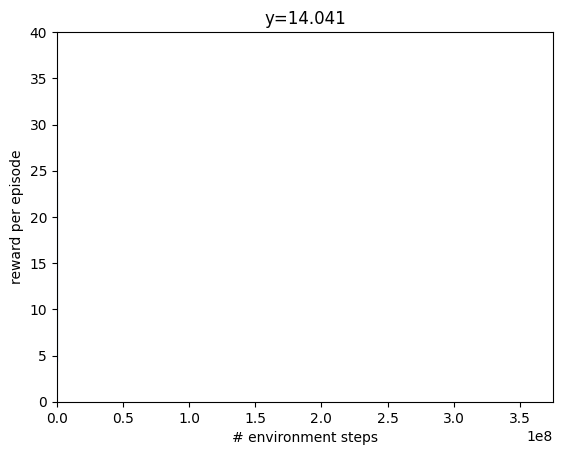

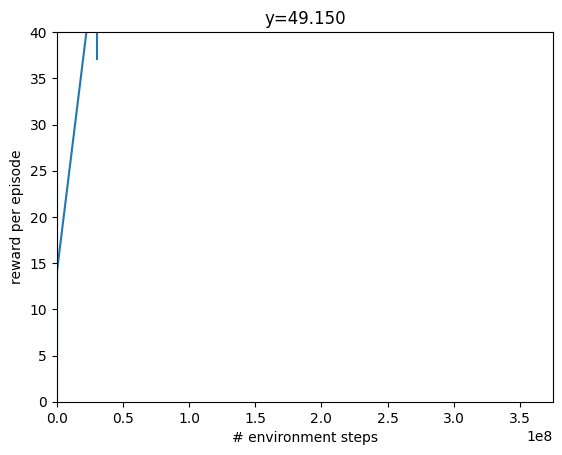

wandb: Adding directory to artifact (output_harsher2/30146560)... Done. 0.0s


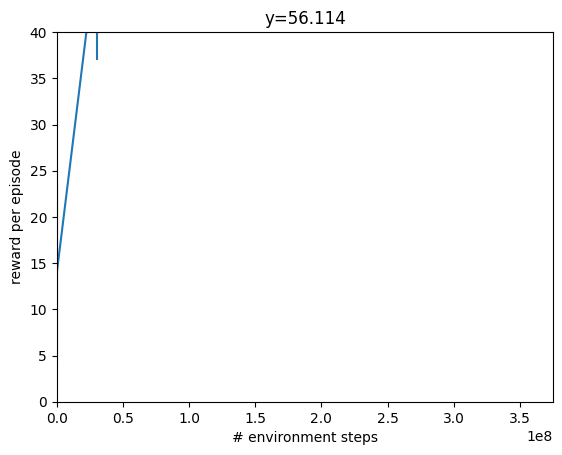

wandb: Adding directory to artifact (output_harsher2/60293120)... Done. 0.0s


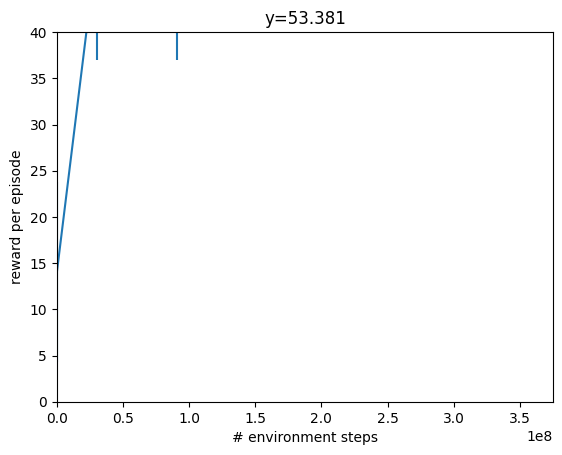

wandb: Adding directory to artifact (output_harsher2/90439680)... Done. 0.0s


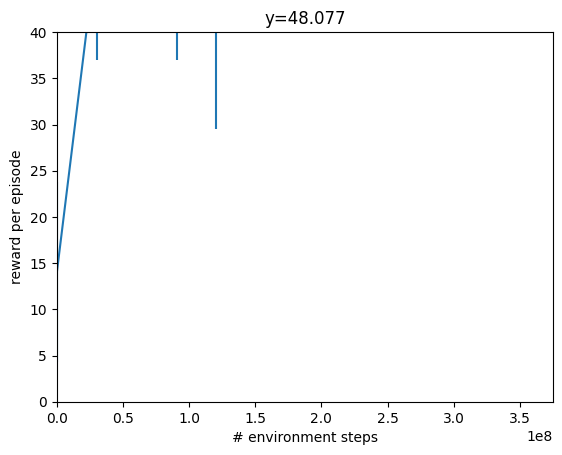

wandb: Adding directory to artifact (output_harsher2/120586240)... Done. 0.0s


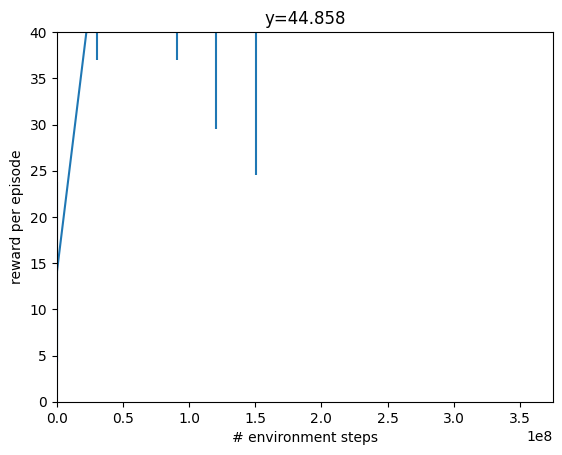

wandb: Adding directory to artifact (output_harsher2/150732800)... Done. 0.0s


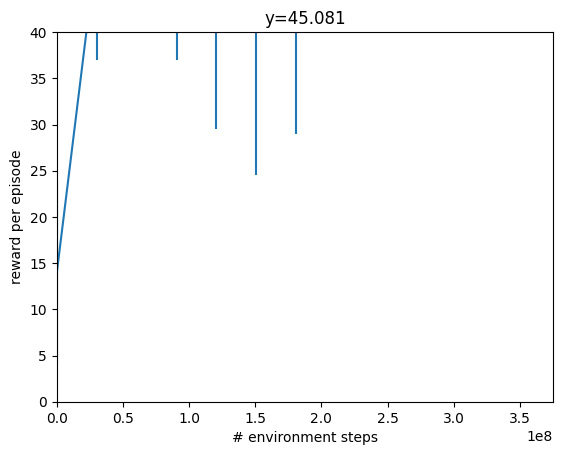

wandb: Adding directory to artifact (output_harsher2/180879360)... Done. 0.0s


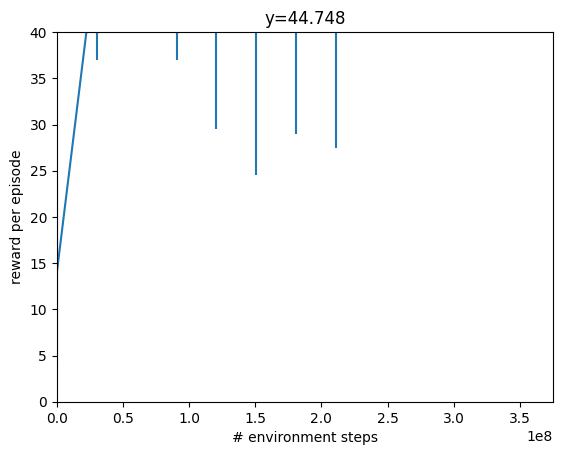

wandb: Adding directory to artifact (output_harsher2/211025920)... Done. 0.0s


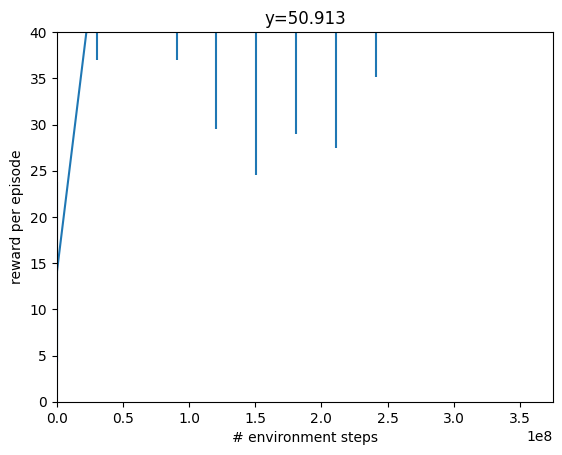

wandb: Adding directory to artifact (output_harsher2/241172480)... Done. 0.0s


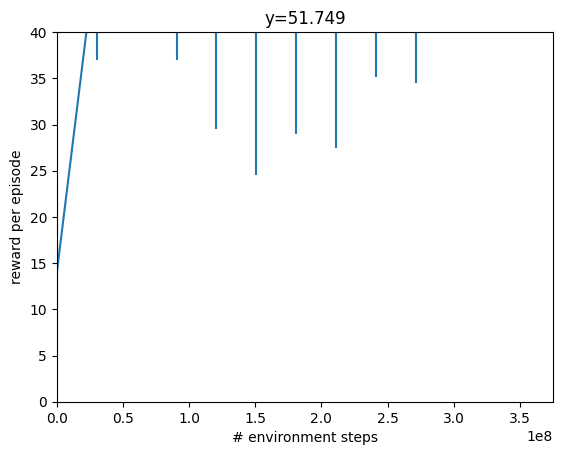

wandb: Adding directory to artifact (output_harsher2/271319040)... Done. 0.0s


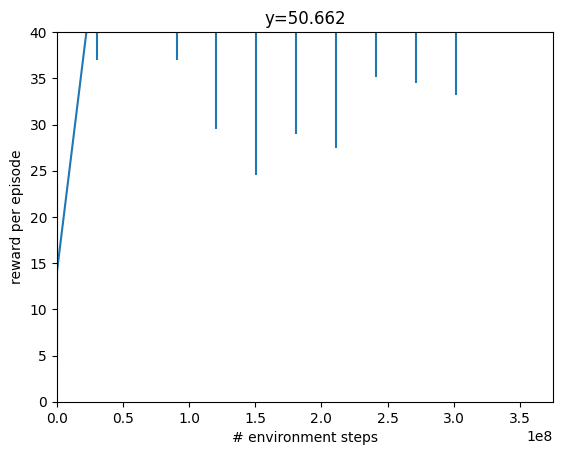

wandb: Adding directory to artifact (output_harsher2/301465600)... Done. 0.0s


time to jit: 0:02:34.002965


In [32]:
from datetime import datetime
from pupperv3_mjx import utils
import importlib
importlib.reload(utils)

train_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


try:
    wandb.init(entity=None,
               project="Wheeled_Pupper",
               name=run_name,
               config=CONFIG.to_dict(),
               save_code=True,
               settings={
                "_service_wait": 90,
                "init_timeout": 90
               })
    print("Using personal W&B to log training progress.")
except wandb.errors.CommError:
    print("W&B failed to initialize. Training without logging (follow W&B specific cells may fail)")

try:
    wandb.run.summary["benchmark_physics_steps_per_sec"] = physics_steps_per_sec
except:
    pass

# Save and reload params.
output_folder = f"output_{wandb.run.name}"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create and JIT reset and step functions for use in in-training policy
# video creation if they don't already exist from a previous step
if ("jit_reset" in globals() or "jit_reset" in locals()) and (
    "jit_step" in globals() or "jit_step" in locals()
):
    print("JIT'd step and reset functions already defined. " "Using them for policy visualization.")
else:
    print("Creating and JIT'ing step and reset functions")
    policy_viz_env = envs.get_environment(env_name, **env_kwargs)
    jit_reset = jax.jit(policy_viz_env.reset)
    jit_step = jax.jit(policy_viz_env.step)


make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
    policy_hidden_layer_sizes=CONFIG.policy.hidden_layer_sizes,
    activation=utils.activation_fn_map(CONFIG.policy.activation)
)
train_fn = functools.partial(
    ppo.train,
    **(CONFIG.training.ppo.to_dict()),
    network_factory=make_networks_factory,
    randomization_fn=functools.partial(
        domain_randomization.domain_randomize,
        friction_range=CONFIG.training.friction_range,
        kp_multiplier_range=CONFIG.training.position_control_kp_multiplier_range,
        kd_multiplier_range=CONFIG.training.position_control_kd_multiplier_range,
        body_com_x_shift_range=CONFIG.training.body_com_x_shift_range,
        body_com_y_shift_range=CONFIG.training.body_com_y_shift_range,
        body_com_z_shift_range=CONFIG.training.body_com_z_shift_range,
        body_mass_scale_range=CONFIG.training.body_mass_scale_range,
        body_inertia_scale_range=CONFIG.training.body_inertia_scale_range,
    ),
    seed=28,
)

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

env = envs.get_environment(env_name, **env_kwargs)
eval_env = envs.get_environment(env_name, **env_kwargs)

def policy_params_fn(current_step, make_policy, params):
    utils.visualize_policy(current_step=current_step,
                           make_policy=make_policy,
                           params=params,
                           eval_env=eval_env,
                           jit_step=jit_step,
                           jit_reset=jit_reset,
                           output_folder=output_folder)
    utils.save_checkpoint(current_step=current_step,
                          make_policy=make_policy,
                          params=params,
                          checkpoint_path=output_folder)

from pathlib import Path
checkpoint_kwargs = {}
if CONFIG.training.checkpoint_run_number is not None:
  utils.download_checkpoint(entity_name=ENTITY,
                            project_name="pupperv3-mjx-rl",
                            run_number=CONFIG.training.checkpoint_run_number,
                            save_path="checkpoint")
  checkpoint_kwargs["restore_checkpoint_path"]=Path("checkpoint").resolve()

make_inference_fn, params, _ = train_fn(
    environment=env,
    progress_fn=functools.partial(
        utils.progress,
        times=times,
        x_data=x_data,
        y_data=y_data,
        ydataerr=ydataerr,
        num_timesteps= CONFIG.training.ppo.num_timesteps,
        min_y=0,
        max_y=40,
    ),
    eval_env=eval_env,
    policy_params_fn=policy_params_fn,
    **checkpoint_kwargs
)

print(f"time to jit: {times[1] - times[0]}")
wandb.run.summary["time_to_jit"] = (times[1] - times[0]).total_seconds()
wandb.run.summary["time_to_train"] = (times[-1] - times[1]).total_seconds()

In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
# Save params to a model
model_path = os.path.join(output_folder, f'mjx_params_{train_datetime}')
model.save_params(model_path, params)

# Visualize Policy

For the Barkour Quadruped, the joystick commands can be set through `x_vel`, `y_vel`, and `ang_vel`. `x_vel` and `y_vel` define the linear forward and sideways velocities with respect to the quadruped torso. `ang_vel` defines the angular velocity of the torso in the z direction.

In [35]:
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)
eval_env = envs.get_environment(env_name, **env_kwargs)

In [36]:
# @markdown Commands **only used for Pupper Env**:
x_vel = 0.75  #@param {type: "number"}
y_vel = 0.  #@param {type: "number"}
ang_vel = 0.  #@param {type: "number"}

the_command = jp.array([x_vel, y_vel, ang_vel])

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
state.info['command'] = the_command
pitch_rad = 0.
state.info['desired_world_z_in_body_frame'] = jp.array([jp.sin(pitch_rad),
                                                        0.0,
                                                        jp.cos(pitch_rad)])
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 300
render_every = 2
ctrls = []

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)

  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)
  ctrls.append(ctrl)

media.show_video(
    eval_env.render(rollout[::render_every], camera='tracking_cam'),
    fps=1.0 / eval_env.dt / render_every)

In [37]:
import numpy as np
from pupperv3_mjx import plotting
plotting.plot_multi_series(data=np.array(ctrls), dt=0.02, display_axes=[0,1,2], title="Policy output")

In [38]:
torques = jp.array([rollout[i].qfrc_actuator[6:] for i in range(len(rollout))]) # ignore world-body joint
plotting.plot_multi_series(data=torques, dt=0.02, display_axes=[0, 1, 2], title="Joint torques")

In [39]:
joint_pos = jp.array([rollout[i].q[7:] for i in range(len(rollout))]) # ignore world-body joint
plotting.plot_multi_series(data=joint_pos, dt=0.02, display_axes=[0, 1, 2], title="Joint Positions")

In [40]:
world_vel = jp.array([rollout[i].qvel[:3] for i in range(len(rollout))])
plotting.plot_multi_series(data=world_vel, dt=0.02, display_axes=[0, 1, 2], title="World Velocity")

# Export Policy for neural_controller

After running the following cells, open the files tab on the left and download policy.json.

In [41]:
import json
from pupperv3_mjx import export
params_rtneural = export.convert_params(jax.block_until_ready(params),
                                        activation=CONFIG.policy.activation,
                                        action_scale=CONFIG.policy.action_scale,
                                        kp=CONFIG.training.position_control_kp,
                                        kd=CONFIG.training.dof_damping,
                                        default_pose=CONFIG.training.default_pose,
                                        joint_upper_limits=CONFIG.simulation.joint_upper_limits,
                                        joint_lower_limits=CONFIG.simulation.joint_lower_limits,
                                        use_imu=CONFIG.policy.use_imu,
                                        observation_history=CONFIG.policy.observation_history,
                                        final_activation="tanh",
                                        maximum_pitch_command=CONFIG.training.maximum_pitch_command,
                                        maximum_roll_command=CONFIG.training.maximum_roll_command
                                        )

name = f"policy.json"
saved_policy_filename = os.path.join(output_folder, name)
with open(saved_policy_filename, "w") as f:
  json.dump(params_rtneural, f)

wandb.log_model(path=saved_policy_filename, name=name)
wandb.log_model(path=model_path, name=f"mjx_policy_network_{wandb.run.name}.pt")
wandb.finish()

eval/avg_episode_length,▁██▇▆▄▅▆▇▇▆
eval/episode_abduction_angle,▆█▆▅▅▆▄▁▁▂▅
eval/episode_abduction_angle_std,▆▁▃▂▂▂▅█▇█▅
eval/episode_action_rate,▁▆▇▇▇██████
eval/episode_action_rate_std,█▂▁▂▂▂▁▂▁▁▁
eval/episode_ang_vel_xy,▅▁▄▅▅▇▇▇▇▇█
eval/episode_ang_vel_xy_std,▁█▃▄█▄▄▅▅▄▃
eval/episode_body_collision,▁▁▁▁▁▁▁▁▁▁▁
eval/episode_body_collision_std,▁▁▁▁▁▁▁▁▁▁▁
eval/episode_feet_air_time,▁▁▁▁▁▁▁▁▁▁▁
+45,...


In [42]:
# # ============================================================================
# # SAVE POLICY TO GOOGLE DRIVE
# # ============================================================================
# # Copy this entire cell into your Colab notebook as the LAST cell.
# # It will:
# #   1. Mount Google Drive
# #   2. Copy the trained policy folder to Google Drive
# #   3. Unassign the runtime to save credits
# #
# # Prerequisites:
# #   - 'output_folder' must be defined from the training cell (line ~2027):
# #       output_folder = f"output_{wandb.run.name}"
# # ============================================================================

# import os
# import shutil
# from google.colab import drive
# from google.colab import runtime

# # 1. Mount Google Drive
# print("Mounting Google Drive...")
# drive.mount('/content/drive')

# # 2. Define Output Paths
# # 'output_folder' should be defined in the previous cells of the notebook
# source_path = output_folder

# # Define where in Drive to save. Change 'Pupper_Policies' if you prefer a different folder.
# drive_base_dir = '/content/drive/My Drive/Pupper_Policies'
# destination_path = os.path.join(drive_base_dir, os.path.basename(source_path))

# print(f"Source: {source_path}")
# print(f"Destination: {destination_path}")

# # 3. Copy files
# if os.path.exists(destination_path):
#     print(f"Destination folder {destination_path} already exists. Removing it to overwrite...")
#     shutil.rmtree(destination_path)

# print("Copying policy files to Google Drive...")
# shutil.copytree(source_path, destination_path)
# print("Successfully saved policy to Google Drive!")

After you are done training and have downloaded the policy, remember to shut down the runtime to save money!

In [43]:
# Give time for wandb to actually finish?
import time
time.sleep(10)

# Helpful for overnight runs
from google.colab import runtime
runtime.unassign()